In [33]:
%matplotlib inline 

import sys
import os
import statistics
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

trainX = pd.read_csv('trainingData.txt','\t', header = None)
trainX.drop(trainX.columns[len(trainX.columns)-1], axis = 1, inplace = True)
trainY = pd.read_csv("trainingTruth.txt", header = None, names = ['Y'])
df = trainX.join(trainY)
# relax the limit a bit, since the cross_val_score is dropping with 1
index = df.isnull().sum(axis=1) == 0
df = df[index]
df.fillna(df.median(), inplace = True)  
# Is it better to delete the rows with NA in the training? Fill in median could mislead the classifier.
# How about dropping all the rows with NA using the following line?
# df.dropna(axis=0, inplace=True) # drop the row with NA in training.
X = df.iloc[:,0:-1].values
Y = df['Y'].values


In [62]:
PLACEHOLDER = -5.0
N_COLS = 300

f = open("trainingData.txt")

cols = []
for col_i in range(N_COLS):
  col = []
  cols.append(col)

rows = []
rows_na = []
n_na = 0
curr_n_na = 0
freq_dict = {}

while True:
  row = f.readline()
  if row == "": break
  features = [float(number) if number != 'NA' else PLACEHOLDER for number in row.split()]

  curr_n_na = 0
  for col_i in range(N_COLS):
    if features[col_i] != PLACEHOLDER:
      cols[col_i].append(features[col_i])
    else:
      n_na += 1
      curr_n_na += 1

  rows.append(features)
  rows_na.append(curr_n_na)

  if curr_n_na in freq_dict:
    freq_dict[curr_n_na] += 1
  else:
    freq_dict[curr_n_na] = 1
f.close()

print ("NA distribution: ",freq_dict)
print ("Total # of NA:", n_na)

medians = []
for col_i in range(N_COLS):
  medians.append(statistics.median(cols[col_i]))

for i, features in enumerate(rows):
  for j, feature in enumerate(features):
    if feature == PLACEHOLDER:
      rows[i][j] = medians[j]

X = np.array(rows)

f = open("trainingTruth.txt")
rows = []
while True:
  row = f.readline()
  if row == "": break
  rows.append(int(row))
f.close()

Y = np.array(rows)

print ("# of each label:", np.bincount(Y))

take = []
for i in range(X.shape[0]):
  if Y[i] == 1 and rows_na[i] == 0:
    take.append(i)
  elif Y[i] == 2 and rows_na[i] == 0:
    take.append(i)
  elif Y[i] == 3:
    take.append(i)

X_take = X[take]
Y_take = Y[take]

print ("# of each label after normalization:", np.bincount(Y_take))


NA distribution:  {0: 8673, 1: 5140, 2: 1575, 3: 327, 4: 51, 5: 4}
Total # of NA: 9495
# of each label: [   0 5667 6147 3956]
# of each label after normalization: [   0 3103 3360 3956]


In [63]:
def print3D(X, x_label, y_label, z_label, title, labels):
    fig = plt.figure(1, figsize=(11, 10))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    
    ax_scatter = ax.scatter(X[:, 1], X[:, 0], X[:, 2], c=labels.astype(np.float), s=50)
    ax.dist = 11

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    
    fig.colorbar(ax_scatter)


/Users/bingao/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


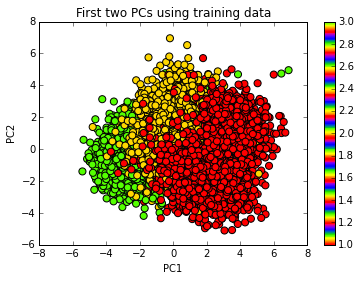

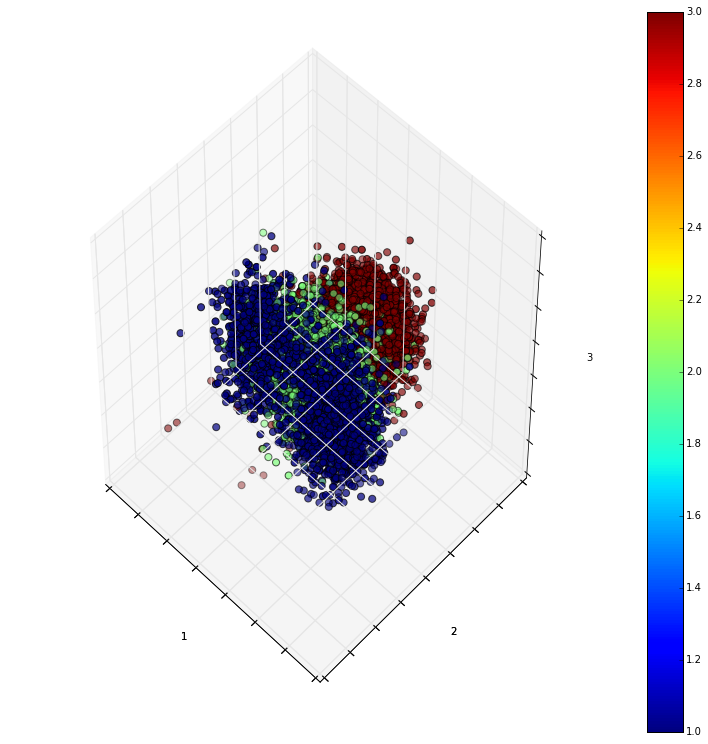

In [64]:
from sklearn import decomposition
from sklearn import preprocessing

svd = decomposition.PCA(n_components=2)
#X_centered = X - np.mean(X, axis=0)  
#I do not think you need this. The PCA function should handle this automatically. 
#You can try with and without, the results are the same.
X_take = preprocessing.scale(X_take)
X_2d = svd.fit_transform(X_take)

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y_take, s = 50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using training data')
plt.colorbar()
plt.show()

X_3d = decomposition.PCA(n_components=3).fit_transform(X_take)
print3D(X_3d, '1', '2', '3', '3D', Y_take)


In [25]:
# Need to install graphviz and pydotplus first
# Run in Mac:
#
# brew install graphviz
# pip install pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

from sklearn import tree
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image #needed to render in notebook

clf = DecisionTreeClassifier(max_depth=3).fit(X, Y)

with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

In [26]:
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("tree.pdf")

True

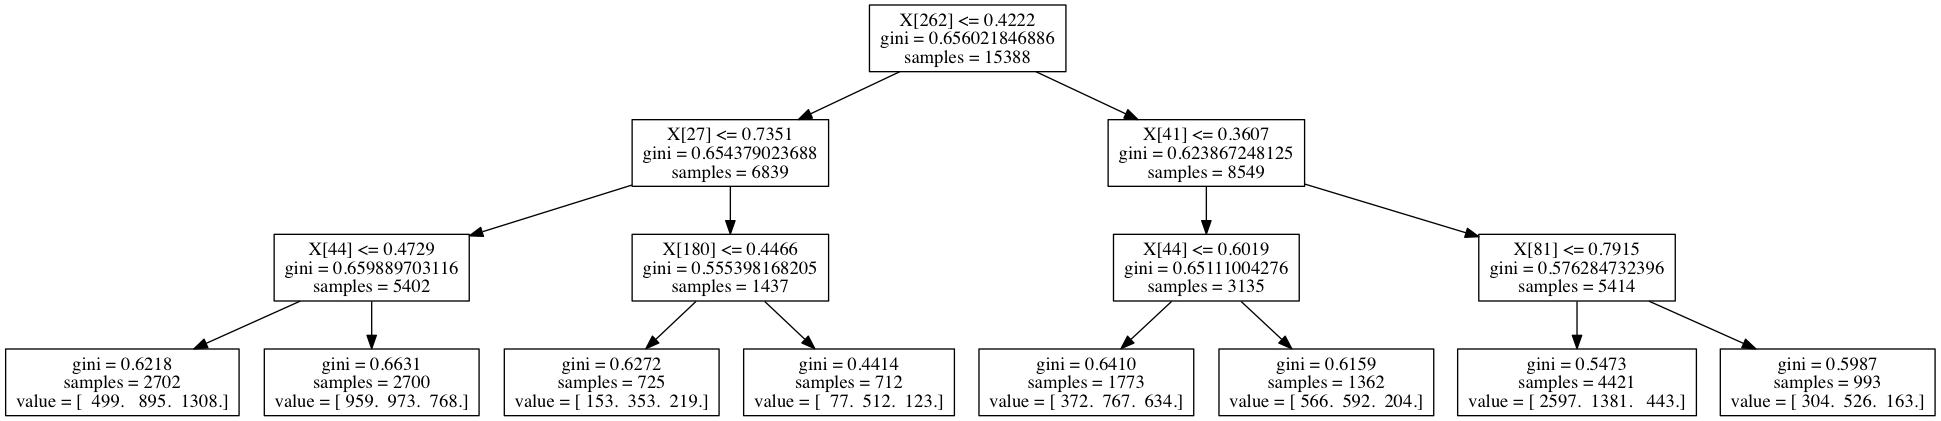

In [27]:
Image(graph.create_png())

In [19]:
clf = RandomForestClassifier(n_estimators=20)
cross_val_score(clf, X, Y, cv=10)

array([ 0.6659436 ,  0.65991317,  0.65340087,  0.65097755,  0.67776973,
        0.65459812,  0.64735699,  0.65749457,  0.65097755,  0.66304348])

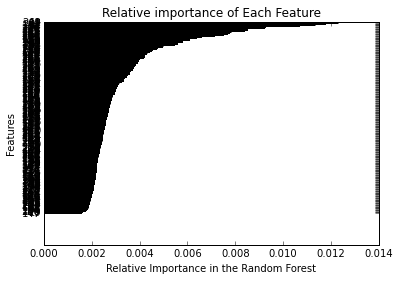

In [34]:
def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired)
    plt.show()

clf = RandomForestClassifier(n_estimators=15)

clf.fit(X,Y)
importance_list = clf.feature_importances_
name_list = map(str, range(X.shape[1]))
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()


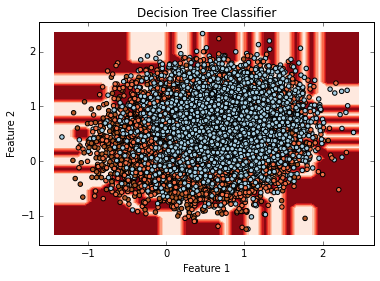

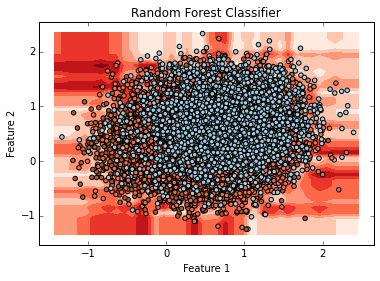

In [35]:
imp_cols = clf.feature_importances_.argsort()[::-1][0:2]
X_imp = X[:,imp_cols]

classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(n_estimators=20)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier']
for c in range(2):
    plt.title(titleClassifer[c])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plot_decision_surface(classifiers[c], X_imp, Y)


[2 3 2 2 1 1 3 1 2 1 2 2 1 2 3 1 2 1 2 3 3 2 3 2 3 1 2 3 3 3]
[False False False False  True  True False  True False  True False False
  True False False  True False  True False False False False False False
 False  True False False False False]
[ True False  True  True False False False False  True False  True  True
 False  True False False  True False  True False False  True False  True
 False False  True False False False]
[False  True False False False False  True False False False False False
 False False  True False False False False  True  True False  True False
  True False False  True  True  True]


/Users/bingao/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


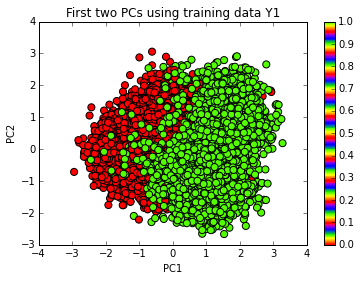

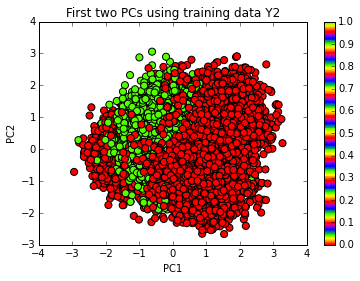

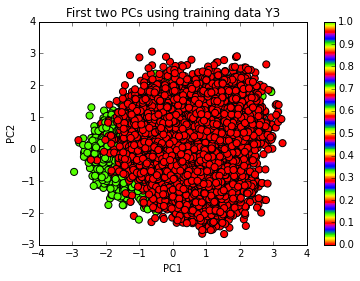

In [3]:
Y1 = Y.copy()
Y1 = Y1 == 1

Y2 = Y.copy()
Y2 = Y2 == 2

Y3 = Y.copy()
Y3 = Y3 == 3

print (Y[:30])
print (Y1[:30])
print (Y2[:30])
print (Y3[:30])

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y1, s = 50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using training data Y1')
plt.colorbar()
plt.show()

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y2, s = 50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using training data Y2')
plt.colorbar()
plt.show()

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y3, s = 50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using training data Y3')
plt.colorbar()
plt.show()


In [33]:
clf = DecisionTreeClassifier(max_depth=3).fit(X, Y1)

with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("tree.pdf")
Image(graph.create_png())

clf = RandomForestClassifier(n_estimators=20)
cross_val_score(clf, X, Y1, cv=10)

array([ 0.8012987 ,  0.79402209,  0.80311891,  0.80181936,  0.79597141,
        0.81351527,  0.79337232,  0.8023407 ,  0.77308192,  0.78673602])

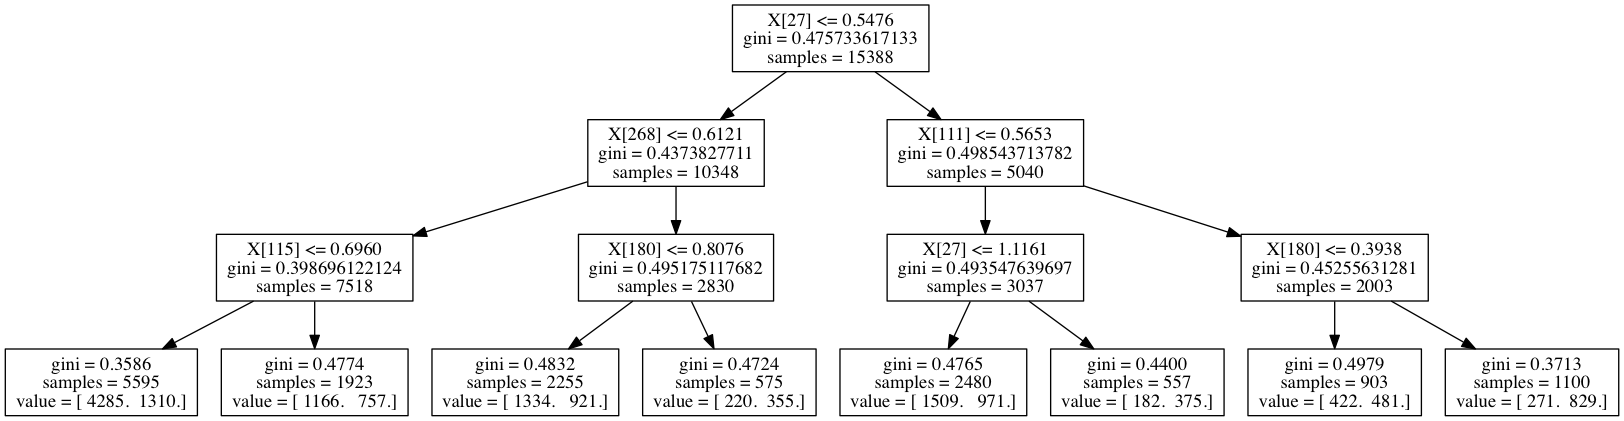

In [31]:
clf = DecisionTreeClassifier(max_depth=3).fit(X, Y2)

with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("tree.pdf")
Image(graph.create_png())

clf = RandomForestClassifier(n_estimators=20)
cross_val_score(clf, X, Y2, cv=10)

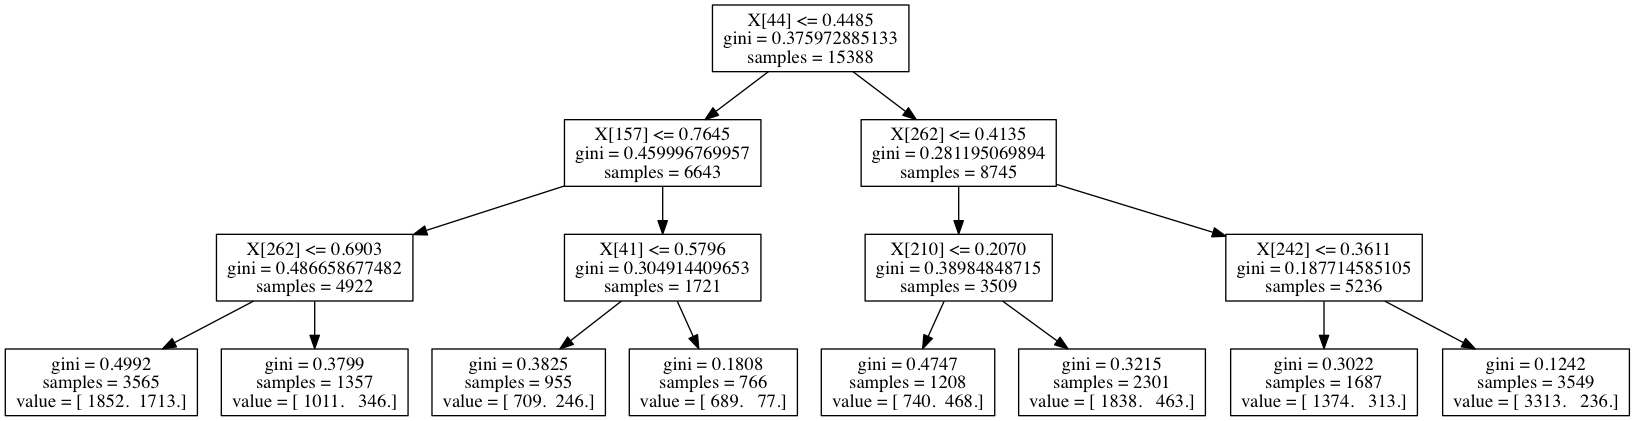

In [32]:
clf = DecisionTreeClassifier(max_depth=3).fit(X, Y3)

with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("tree.pdf")
Image(graph.create_png())

clf = RandomForestClassifier(n_estimators=20)
cross_val_score(clf, X, Y3, cv=10)

/Users/bingao/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


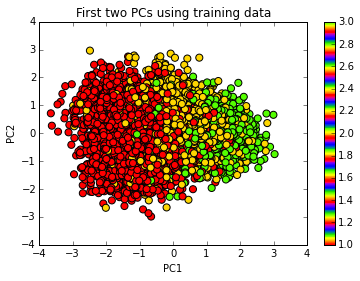

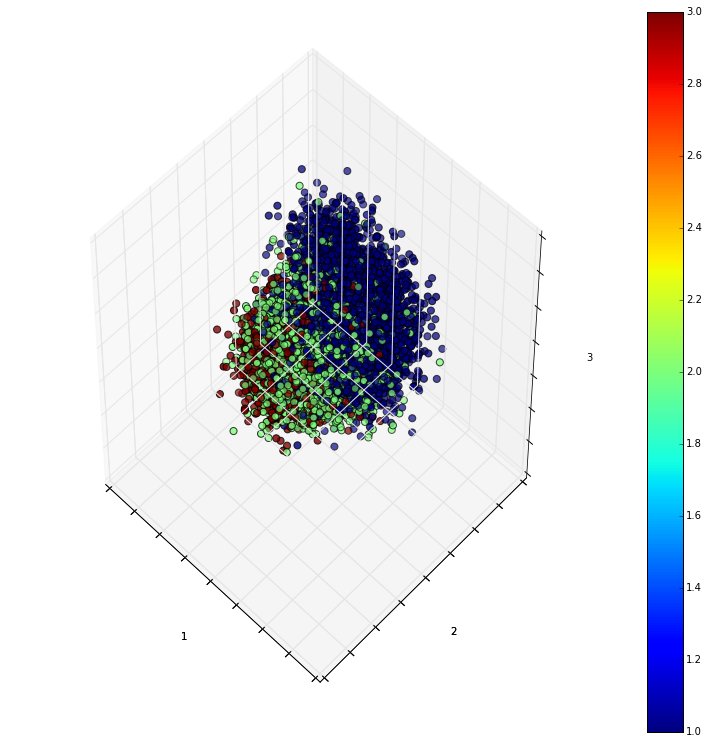

In [49]:
trainX = pd.read_csv('testData.txt','\t', header = None)
trainX.drop(trainX.columns[len(trainX.columns)-1], axis = 1, inplace = True)
trainY = pd.read_csv("firstTryTestSubmission.txt", '\t', header = None, names = ['Y'])
df = trainX
X = df.iloc[:,0:-1].values
X_2d = svd.fit_transform(X)
Y = trainY.iloc[:,len(trainY.columns)-1].values

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y, s = 50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using training data')
plt.colorbar()
plt.show()

X_3d = decomposition.PCA(n_components=3).fit_transform(X)
print3D(X_3d, '1', '2', '3', '3D', Y)


/Users/bingao/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


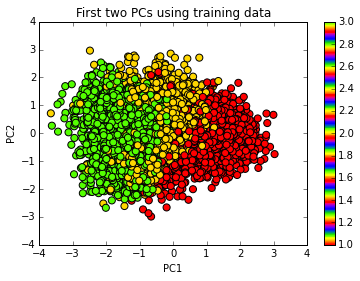

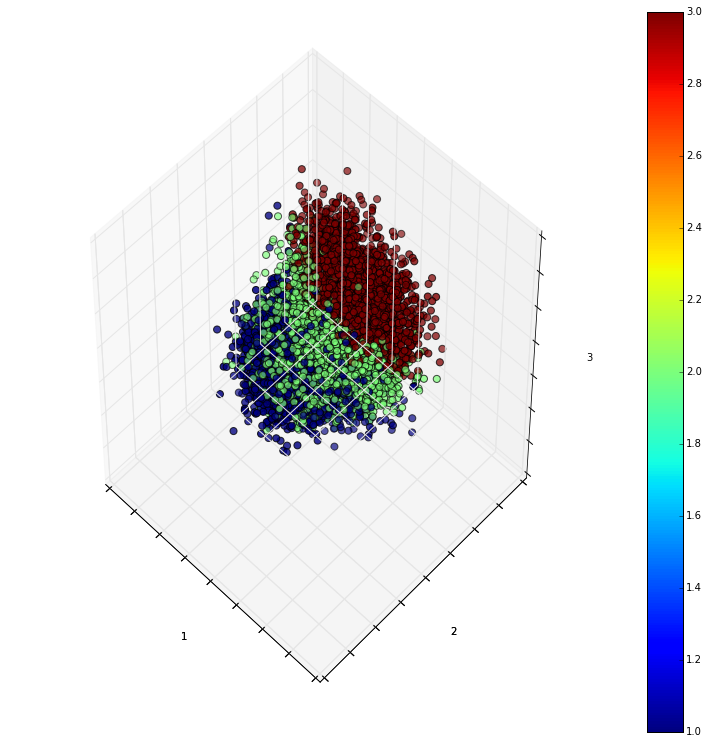

In [50]:
trainX = pd.read_csv('testData.txt','\t', header = None)
trainX.drop(trainX.columns[len(trainX.columns)-1], axis = 1, inplace = True)
trainY = pd.read_csv("testY_1114.txt", '\t', header = None, names = ['Y'])
df = trainX
X = df.iloc[:,0:-1].values
X_2d = svd.fit_transform(X)
Y = trainY.iloc[:,len(trainY.columns)-1].values

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y, s = 50, cmap=plt.cm.prism)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs using training data')
plt.colorbar()
plt.show()

X_3d = decomposition.PCA(n_components=3).fit_transform(X)
print3D(X_3d, '1', '2', '3', '3D', Y)
